# scClusterMetric - Clustering Pipeline

## Package
---

In [3]:
# utils
import sys
import time
import scipy
import logging
import numpy as np
import pandas as pd
from collections import Counter

# scRBA
import anndata
import scanpy as sc
from sklearn.metrics.cluster import normalized_mutual_info_score


%load_ext autoreload
%autoreload 2

Autosaving every 5 seconds


In [2]:
# custome functions
from pipeline import *

/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



## Data Loading & Preprocessing

#### data loading

In [14]:
# load data 
DATA_PATH = '/projects/zhanglab/data/sc_data/TMS_2020/tabula-muris-senis-facs-official-raw-obj.h5ad' # TMS fasq
# DATA_PATH = '/projects/zhanglab/data/sc_data/TMS_2020/tabula-muris-senis-droplet-official-raw-obj.h5ad' # TMS droplet: 
# DATA_PATH = '/projects/zhanglab/data/sc_data/TS_Science_2022/obj_smartseq2_raw.h5ad' # TS fasq
# DATA_PATH = '/projects/zhanglab/data/sc_data/TS_Science_2022/obj_10X_raw.h5ad' # TS droplet  445777 × 2613
# DATA_PATH = '/projects/zhanglab/data/sc_data/nathan_2021/raw.h5ad' # TS droplet  445777 × 2613
adata = read_TMS(DATA_PATH)

# select HVG
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, subset=True)
adata

/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


AnnData object with n_obs × n_vars = 110823 × 2800
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

#### fileter tissue

In [26]:
# Counter(adata.obs['tissue'])

In [ ]:
adata = adata[adata.obs['tissue']=='Lung']
adata

#### filter number of clusters

In [ ]:
# label = 'cluster_name' # 
label = 'free_annotation'
adata = top_k_labels(adata, label = label, k = 12)

print('number of labels (#k):', len(Counter(adata.obs[label])))
adata

In [29]:
Counter(adata.obs[label])

Counter({'CD4+ CD27+CD161+': 45519,
         'CD4+ CD27+': 40431,
         'CD4+ Th17/1': 39205,
         'CD4+ Th1': 37566,
         'CD4+ CCR4+ central': 28951,
         'CD4+ CCR4+ICOS+ central': 27770,
         'CD4+ central': 26701,
         'CD4+ Treg': 25270,
         'CD4+ cytotoxic': 23213,
         'CD4+ Th2': 20696,
         'CD4+ lncRNA': 19901,
         'CD4+ CD161+ Th1': 17731})

#### Cluster Label (using Cell Ontology Class)

In [76]:
labels, labels_dict = label_encode(adata.obs[label])
adata.obs['label'] = labels
adata

/tmp/ipykernel_11337/3122864200.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['label'] = labels


AnnData object with n_obs × n_vars = 9825 × 1714
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'tissue', 'tissue_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

## Testing

### PCoA

In [48]:
X = np.array([
    [1, 0, 3],
    [4, 2, 6],
    [7, 8, 9]
]).T  # Transpose to make rows as observations

X = X - np.mean(X, axis=0)

print('X:\n', X)
print('D:\n',squareform(pdist(X, metric='euclidean')))

X:
 [[-0.33333333  0.         -1.        ]
 [-1.33333333 -2.          0.        ]
 [ 1.66666667  2.          1.        ]]
D:
 [[0.         2.44948974 3.46410162]
 [2.44948974 0.         5.09901951]
 [3.46410162 5.09901951 0.        ]]


#### PCoA

In [56]:
from skbio.stats.distance import DistanceMatrix
from skbio.stats import ordination
from scipy.spatial.distance import pdist, squareform, euclidean

# L2 distance matrix
D = squareform(pdist(X, metric='euclidean'))

# PCoA
k = 2
pc_skbio = ordination.pcoa(DistanceMatrix(D, ids = list(range(3))), number_of_dimensions=k)
print(pc_skbio.samples)

        PC1       PC2
0 -0.439349  0.958167
1 -2.326819 -0.603068
2  2.766168 -0.355098


#### PCA

In [86]:
I = np.ones(5)
n = 5 
J =  - 1/n * np.outer(I, I)
print('J:\n', J)
print('0:\n',J @ I)


J:
 [[-0.2 -0.2 -0.2 -0.2 -0.2]
 [-0.2 -0.2 -0.2 -0.2 -0.2]
 [-0.2 -0.2 -0.2 -0.2 -0.2]
 [-0.2 -0.2 -0.2 -0.2 -0.2]
 [-0.2 -0.2 -0.2 -0.2 -0.2]]
0:
 [-1. -1. -1. -1. -1.]


In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca_coords = pca.fit_transform(X)
print('PCs:\n',pca_coords)

PCs:
 [[-0.43934865  0.95816694]
 [-2.3268189  -0.60306849]
 [ 2.76616754 -0.35509845]]


In [91]:
import numpy as np

print(X)
print("Numpy  covariance matrix:\n", np.cov(X.T))
print("Manual covariance matrix:\n", (X.T @ X) / (X.shape[0] - 1))

[[-0.33333333  0.         -1.        ]
 [-1.33333333 -2.          0.        ]
 [ 1.66666667  2.          1.        ]]
Numpy  covariance matrix:
 [[2.33333333 3.         1.        ]
 [3.         4.         1.        ]
 [1.         1.         1.        ]]
Manual covariance matrix:
 [[2.33333333 3.         1.        ]
 [3.         4.         1.        ]
 [1.         1.         1.        ]]


In [ ]:
data = sc.pp.subsample(adata, fraction = 0.01, copy = True, random_state = 42) 
data  = data[:100]
# data = data.X.toarray()
data.shape

In [104]:
data = np.array([[0.        , 0.29618223, 1.98029366],
                 [0.29618223, 0.        , 1.8302808 ],
                 [1.98029366, 1.8302808 , 0.        ]])
from skbio.stats.distance import DistanceMatrix
from skbio.stats import ordination
dm = DistanceMatrix(squareform(pdist(data, metric='euclidean')), ids = list(range(3)))
pc_skbio = ordination.pcoa(dm, number_of_dimensions=2, inplace=True)
print(pc_skbio.samples.values)

[[-1.09785242  0.21225396]
 [-0.99092452 -0.21962346]
 [ 2.08877695  0.0073695 ]]


In [101]:
from sklearn.decomposition import PCA

a = np.array(data)
pca = PCA(n_components=2, svd_solver='full')
pca_coords = pca.fit_transform(a)
pca_coords

array([[-1.09785242, -0.21225396],
       [-0.99092452,  0.21962346],
       [ 2.08877695, -0.0073695 ]])

In [110]:
X = np.array([
    [1, 0, 3],
    [4, 2, 6],
    [7, 8, 9],
    [0, 2, 1]
])
X

array([[1, 0, 3],
       [4, 2, 6],
       [7, 8, 9],
       [0, 2, 1]])

In [120]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12]])

# Compute the covariance matrix
covariance_matrix = np.dot(X.T, X)

# Perform eigendecomposition of covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eig(covariance_matrix)

print("Eigenvalues of Covariance Matrix (X^TX):\n", eigenvalues_cov)
print("\nEigenvectors of Covariance Matrix (X^TX):\n", eigenvectors_cov)

# Compute the Gram matrix
Gram = np.dot(X, X.T)

# Perform eigendecomposition of Gram matrix
eigenvalues_gram, eigenvectors_gram = np.linalg.eigh(Gram)

print("Eigenvalues of Gram Matrix (XX^T):\n", eigenvalues_gram)
print("\nEigenvectors of Gram Matrix (XX^T):\n", eigenvectors_gram)



Eigenvalues of Covariance Matrix (X^TX):
 [ 6.47032607e+02  2.96739296e+00 -1.80720805e-14 -6.18478049e-17]

Eigenvectors of Covariance Matrix (X^TX):
 [[-4.03617572e-01  7.32866192e-01  4.89586905e-01 -1.19976920e-04]
 [-4.64744130e-01  2.89849777e-01 -8.35819668e-01 -4.08088311e-01]
 [-5.25870689e-01 -1.53166638e-01  2.02878621e-01  8.16536554e-01]
 [-5.86997247e-01 -5.96183053e-01  1.43354142e-01 -4.08328265e-01]]
Eigenvalues of Gram Matrix (XX^T):
 [-1.91892689e-14  2.96739296e+00  6.47032607e+02]

Eigenvectors of Gram Matrix (XX^T):
 [[ 0.40824829 -0.88915331 -0.20673589]
 [-0.81649658 -0.25438183 -0.51828874]
 [ 0.40824829  0.38038964 -0.82984158]]


In [121]:
import numpy as np

# Example matrix X
X = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

# Compute the covariance matrix
covariance_matrix = np.dot(X.T, X)

# Perform eigendecomposition of covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eig(covariance_matrix)

# Compute the Gram matrix
Gram = np.dot(X, X.T)

# Perform eigendecomposition of Gram matrix
eigenvalues_gram, eigenvectors_gram = np.linalg.eigh(Gram)

# Transform eigenvectors obtained from Gram matrix
transformed_eigenvectors_gram = np.dot(np.linalg.inv(np.diag(np.sqrt(eigenvalues_cov))), eigenvectors_cov.T).T

# Compare eigenvectors
print("Original Eigenvectors of Covariance Matrix (X^TX):\n", eigenvectors_cov)
print("\nTransformed Eigenvectors obtained from Gram Matrix (XX^T):\n", transformed_eigenvectors_gram)

# Calculate the dot product between the original and transformed eigenvectors
dot_products = np.abs(np.diag(np.dot(eigenvectors_cov.T, transformed_eigenvectors_gram.T)))

print("\nDot Products between corresponding eigenvectors:")
for i, dp in enumerate(dot_products):
    print("Eigenvector", i+1, ":", dp)


Original Eigenvectors of Covariance Matrix (X^TX):
 [[-0.47967118 -0.77669099  0.40824829]
 [-0.57236779 -0.07568647 -0.81649658]
 [-0.66506441  0.62531805  0.40824829]]

Transformed Eigenvectors obtained from Gram Matrix (XX^T):
 [[-2.84703369e-02 -7.26987227e-01  1.26846926e+07]
 [-3.39722390e-02 -7.08429706e-02 -2.53693851e+07]
 [-3.94741412e-02  5.85301285e-01  1.26846926e+07]]

Dot Products between corresponding eigenvectors:
Eigenvector 1 : 8436137.152720341
Eigenvector 2 : 15863934.419446098
Eigenvector 3 : 5178503.563696462


In [122]:
import numpy as np

# Compute the covariance matrix
covariance_matrix = np.dot(X.T, X)

# Perform eigendecomposition of covariance matrix
eigenvalues_cov, eigenvectors_cov = np.linalg.eig(covariance_matrix)

# Compute the singular values and create the diagonal matrix
Sigma = np.sqrt(np.diag(eigenvalues_cov))

# Transform eigenvectors obtained from Gram matrix
transformed_eigenvectors_gram = np.dot(np.linalg.inv(Sigma), np.dot(eigenvectors_cov.T, X.T)).T
transformed_eigenvectors_gram

array([[-2.14837238e-01,  8.87230688e-01,  3.29434571e-07],
       [-5.20587389e-01,  2.49643953e-01,  1.06936877e-07],
       [-8.26337541e-01, -3.87942782e-01, -1.08661665e-07]])

In [ ]:
# Exclude zero eigenvalues
nonzero_indices = eigenvalues > 0
U = U[:, nonzero_indices]
eigenvalues = eigenvalues[nonzero_indices]

# Compute the singular values and create the diagonal matrix
Sigma = np.sqrt(np.diag(eigenvalues))

# Compute V using the relation V = Σ^-1 * U^T * X
V = np.dot(np.linalg.pinv(Sigma), np.dot(U.T, X))

# Now, V contains the eigenvectors of the original matrix X
print("Eigenvectors of X:\n", V)


### Leiden

PCA

In [77]:
sc.pp.subsample(adata, fraction = 0.7, copy = True, random_state = 42) 

AnnData object with n_obs × n_vars = 6877 × 1714
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'tissue', 'tissue_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [85]:
# leiden clustering
data = sc.pp.subsample(adata, fraction = 0.7, copy = True, random_state = 99999) 
## PCA
start_time = time.time()
sc.tl.pca(data, svd_solver='arpack')
print("PCA running time:", time.time() - start_time)
## KNN
sc.pp.neighbors(data, n_neighbors = 10, n_pcs=40, metric = 'l1', use_rep = 'X_pca', key_added = 'neighbors_pca')
## Leiden
sc.tl.leiden(data, resolution = 0.4,  neighbors_key = 'neighbors_pca', key_added  = 'leiden_pca')
len(data.obs['leiden_pca'].unique())

PCA running time: 1.0558085441589355


12

In [ ]:
Counter(adata.obs['leiden'])

PCoA(MDS)

### BanditPAM

In [7]:
kmed = KMedoids(n_medoids = 11, algorithm="BanditPAM")
kmed.fit(data.X.toarray(), 'cos')
data.obs['cos'] = pd.Series(kmed.labels, index=data.obs.index, dtype="category")

In [150]:
len(data.obs['label_2'].unique())

12

In [12]:
data.obs['cos'] = pd.Categorical(values=kmed.labels, categories=np.unique(kmed.labels))

### clustering result

/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/chunchua/miniconda3/envs/lab/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


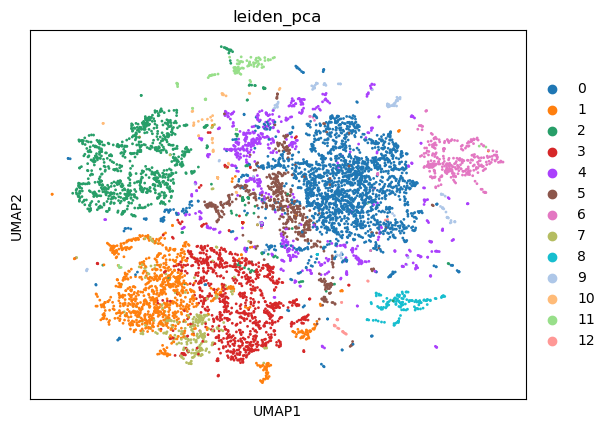

In [21]:
# UMAP embedding based on KNN
sc.tl.umap(data)
sc.pl.umap(data, color = ['leiden_pca'])#, 'leiden_pcoa', 'label_2'])

In [22]:
normalized_mutual_info_score(data.obs['label_2'], data.obs['leiden_pca'])

0.7211077325181372

In [140]:
## KNN
sc.pp.neighbors(data, n_neighbors = 10, metric = 'correlation', use_rep = 'X_pcoa', key_added = 'neighbors_pcoa')
## Leiden
sc.tl.leiden(data, resolution = 0.3, neighbors_key = 'neighbors_pcoa', key_added  = 'leiden_pcoa')
normalized_mutual_info_score(data.obs['label_2'], data.obs['leiden_pcoa'])

0.9444014966872378

## Experiment

In [69]:
# res = pd.DataFrame(columns=['trial', 'dataset', 'algorithm', 'rd_metric', 'alg_metric', 'NMI', 'time', '#k'])
res = pd.read_csv('results_0410.csv')
res

,trial,dataset,algorithm,rd_metric,alg_metric,NMI,time,#k
0,0,TMS_fasq,leiden,pca,l1,0.931625,31.252245,12
1,0,TMS_fasq,leiden,pca,l2,0.917861,6.534030,13
2,0,TMS_fasq,leiden,pca,cosine,0.920898,7.414764,13
3,0,TMS_fasq,leiden,pca,correlation,0.924909,7.523328,14
4,0,TMS_fasq,leiden,l1,l1,0.941711,1.037526,12
...,...,...,...,...,...,...,...,...
1135,11,nathon,leiden,cosine,correlation,0.292608,3.484659,12
1136,11,nathon,leiden,correlation,l1,0.281051,3.762311,11
1137,11,nathon,leiden,correlation,l2,0.287533,3.723651,10
1138,11,nathon,leiden,correlation,cosine,0.281199,4.062556,10


In [20]:
sc.pp.subsample(adata, fraction = 0.045, copy = True, random_state =42+72221) 

AnnData object with n_obs × n_vars = 6905 × 2613
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'tissue', 'tissue_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'label'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'sex_colors', 'tissue_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [86]:
import time
import numpy as np
import pandas as pd
import scipy
import scanpy as sc
from banditpam import KMedoids
from collections import Counter
from sklearn.metrics import normalized_mutual_info_score

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

def get_stats(data, start_time, key):
    run_time = time.time() - start_time
    nmi = normalized_mutual_info_score(data.obs[label], data.obs[key])
    k = len(np.unique(data.obs[key]))
    return run_time, nmi, k

metric_dict = {
    'leiden': ['l1','l2','cosine','correlation'],
    'banditpam': ['L1', 'L2', 'cos', 'pearson'],
}
rd_metrics = ['pca', 'l1','l2','cosine','correlation']
# algorithms = ['banditpam', 'leiden']
algorithms = ['leiden']
n_trials = 15
resolution =  0.4


K = 12

for trial in range(n_trials):

    # load data & sampling
    data = adata.copy()
    data = sc.pp.subsample(data, fraction = 0.7, copy = True, random_state = 42 * trial+42+66787) 
    ## convert to dense matrix
    data.X = data.X.toarray()
    

    # preprocess
    ## pca
    sc.tl.pca(data, svd_solver='arpack')

    ## pcoa
    for metric in ['l1','l2','cosine','correlation']:
        dist_matrix = distance_matrix(data, metric)
        data.obsm[f'X_{metric}'] = pcoa(dist_matrix, n_components=50)

    for alg in algorithms:
        for rd_metric in rd_metrics:
            for alg_metric in metric_dict[alg]:
                key = f'{alg}_{rd_metric}_{alg_metric}'

                start_time = time.time()
                if alg == 'leiden':
                    sc.pp.neighbors(data, n_neighbors = 10, metric = alg_metric, use_rep = f'X_{rd_metric}', key_added = f'neighbors_{rd_metric}')
                    sc.tl.leiden(data, resolution=resolution, neighbors_key = f'neighbors_{rd_metric}', key_added=key)
                elif alg == 'banditpam': 
                    kmed = KMedoids(n_medoids=K, algorithm="BanditPAM")
                    kmed.fit(data.obsm[f'X_{rd_metric}'], alg_metric)
                    data.obs[key] = pd.Categorical(values=kmed.labels, categories=np.unique(kmed.labels))
                
                
                run_time, nmi, k = get_stats(data, start_time, key = key)

                new_entry = {
                    'trial': trial,
                    'dataset': 'TS_faasq',
                    'algorithm': alg,
                    'rd_metric': rd_metric,
                    'alg_metric': alg_metric,
                    'NMI': nmi,
                    'time': run_time,
                    '#k': k
                } 
                res.loc[len(res.index)] = new_entry.values() 


                
                print(f"Algorithm: {alg[0]}, Trial: {trial}, Feature: {rd_metric[:3]}, Metric: {alg_metric[:3]}\t, NMI: {nmi}, \t Time: {run_time}", "k:", k)
                
                res.to_csv('results_0410.csv', index=False)


Algorithm: l, Trial: 0, Feature: pca, Metric: l1	, NMI: 0.7967160151104139, 	 Time: 2.0159807205200195 k: 12
Algorithm: l, Trial: 0, Feature: pca, Metric: l2	, NMI: 0.8080674525584121, 	 Time: 1.6986353397369385 k: 13
Algorithm: l, Trial: 0, Feature: pca, Metric: cos	, NMI: 0.7886903885026525, 	 Time: 1.7922754287719727 k: 15
Algorithm: l, Trial: 0, Feature: pca, Metric: cor	, NMI: 0.7840238929302813, 	 Time: 1.874445915222168 k: 15
Algorithm: l, Trial: 0, Feature: l1, Metric: l1	, NMI: 0.8058845621148968, 	 Time: 1.8269364833831787 k: 12
Algorithm: l, Trial: 0, Feature: l1, Metric: l2	, NMI: 0.7996878475250441, 	 Time: 1.937988519668579 k: 13
Algorithm: l, Trial: 0, Feature: l1, Metric: cos	, NMI: 0.7894796459193989, 	 Time: 1.4618589878082275 k: 15
Algorithm: l, Trial: 0, Feature: l1, Metric: cor	, NMI: 0.7907878257989668, 	 Time: 1.7764227390289307 k: 16
Algorithm: l, Trial: 0, Feature: l2, Metric: l1	, NMI: 0.7966210066175274, 	 Time: 1.8544731140136719 k: 12
Algorithm: l, Trial: 0

In [ ]:
# testing server
print('42')